In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics.pairwise as pw
import wordcloud
from wordcloud import WordCloud, STOPWORDS
from scipy import sparse
import ast

import warnings
warnings.filterwarnings('ignore')

In [6]:
df_genome_score = pd.read_csv('genome-scores.csv')
df_genome_score.head()

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


In [5]:
df_genome_tags = pd.read_csv('genome-tags.csv')
df_genome_tags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [35]:
# df_links = pd.read_csv('links.csv')
# df_links.head()

In [2]:
df_movies = pd.read_csv('movies.csv')
df_movies_copy = df_movies.copy()
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
df_movies.shape

(27278, 3)

In [5]:
print('Number of movies: ',len(df_movies['movieId'].value_counts()))

Number of movies:  27278


### Visualization to find if there were any words which used to repeat in most of the movies

In [6]:
# Create a wordcloud of the movie titles
df_movies['title'] = df_movies['title'].fillna("").astype('str')
title_corpus = ' '.join(df_movies['title'])

In [7]:
len(title_corpus)

787835

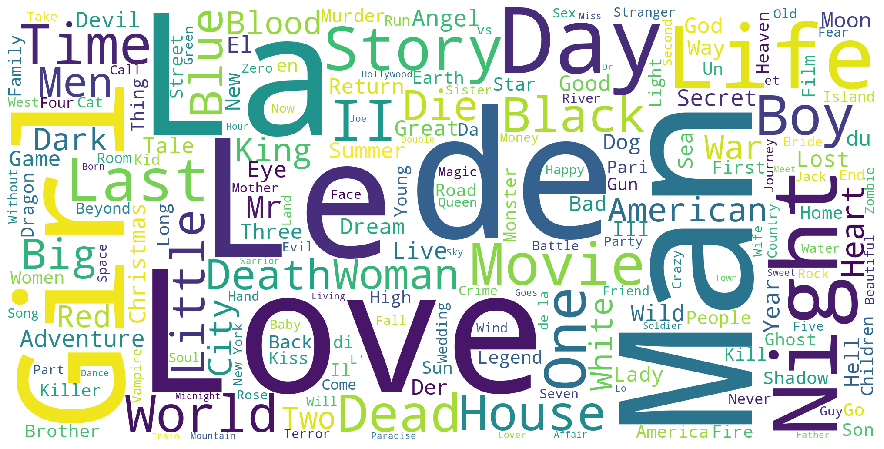

In [8]:
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=1000, width=2000).generate(title_corpus)
# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

In [9]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
df_ratings = pd.read_csv('ratings.csv')
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [11]:
# Checking for duplicated movieIDs
display(df_movies['movieId'].value_counts().sort_values(ascending=False).head()) 


131072    1
120891    1
116793    1
59421     1
2049      1
Name: movieId, dtype: int64

In [12]:
# Checking for duplicated titles
display(df_movies['title'].value_counts().sort_values(ascending=False).head(10) > 1)



20,000 Leagues Under the Sea (1997)    True
Chaos (2005)                           True
Paradise (2013)                        True
War of the Worlds (2005)               True
Men with Guns (1997)                   True
Emma (1996)                            True
Aladdin (1992)                         True
Clear History (2013)                   True
Johnny Express (2014)                  True
Hamlet (2000)                          True
Name: title, dtype: bool

In [13]:
# Extracting duplicated movie ids
duplicate_movies = df_movies.groupby('title').filter(lambda x: len(x) == 2)
duplic_ids = duplicate_movies['movieId'].values
#Duplicated titles
duplicate_movies = duplicate_movies[['movieId','title']]
# Checking the id with most reviews
review_count = pd.DataFrame(df_ratings[df_ratings['movieId'].isin(duplic_ids)]['movieId'].value_counts())
review_count.reset_index(inplace=True)
review_count.columns = ['movieId','count']
duplicated_df = pd.merge(duplicate_movies, review_count, on='movieId')
display(duplicated_df)
## Getting duplicates with low review count
duplicated_df.sort_values(by=['title','count'],ascending=[True,False])
duplicated_ids = duplicated_df.drop_duplicates(subset ="title", 
                     keep = 'last', inplace = False)['movieId']


,movieId,title,count
0,588,Aladdin (1992),41842
1,838,Emma (1996),7938
2,1788,Men with Guns (1997),683
3,3598,Hamlet (2000),1168
4,26958,Emma (1996),19
5,26982,Men with Guns (1997),32
6,34048,War of the Worlds (2005),6456
7,42015,Casanova (2005),578
8,47254,Chaos (2005),244
9,48682,Offside (2006),88


In [14]:
# Removing duplicated ids with low review count from movie database
df_movies = df_movies.loc[~df_movies['movieId'].isin(duplicated_ids)]
# Removing duplicated ids with low review count from rating database
df_ratings = df_ratings.loc[~df_ratings['movieId'].isin(duplicated_ids)]


In [15]:
display(df_movies['movieId'].value_counts().sort_values(ascending=False).head()) 



131072    1
120891    1
116793    1
59421     1
2049      1
Name: movieId, dtype: int64

In [16]:
display(df_movies['title'].value_counts().sort_values(ascending=False).head(10) > 1)



Firm, The (1993)                                                            False
12 O'Clock Boys (2013)                                                      False
Back Soon (2007)                                                            False
Little Mermaid: Ariel's Beginning, The (2008)                               False
Life Is a Long Quiet River (La vie est un long fleuve tranquille) (1988)    False
Dragonfly (2002)                                                            False
Karate Kid, The (1984)                                                      False
Shoes of the Fisherman, The (1968)                                          False
Radio Days (1987)                                                           False
Heart Like a Wheel (1983)                                                   False
Name: title, dtype: bool

In [17]:
#creating list with unique genres
genres = list(set('|'.join(list(df_movies["genres"].unique())).split('|')))
genres.remove('(no genres listed)')

#Creating dummy columns for each genre
for genre in genres:
    df_movies[genre] = df_movies['genres'].map(lambda val: 1 if genre in val else 0)

In [18]:
df_movies.head()

,movieId,title,genres,Sci-Fi,Drama,Western,Horror,Musical,Romance,Comedy,...,Crime,Animation,Documentary,Thriller,Fantasy,Film-Noir,War,Mystery,Children,Adventure
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,0,0,0,0,1,...,0,1,0,0,1,0,0,0,1,1
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,1
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# import re
# #Creating colum with film year
# df_movies['year'] = df_movies['title'].map(lambda val: int(re.search('\(([0-9]{4})\)',val).group(1)) 
#                                      if re.search('\(([0-9]{4})\)',val)!= None 
#                                      else 0)   
# # Film Decade
# for decade in range(1930,2020,10):
#     df_movies['decade_'+str(decade)] = np.where((df_movies['year'] < decade+10) & (df_movies['year'] >= decade) ,1,0)
# #     print('column created','decade_' + str(decade))
    
# df_movies['decade_none'] = np.where(df_movies['year'] == 0 ,1,0)
# df_movies['decade_other'] = np.where((df_movies['year'] != 0) & (df_movies['year'] <1930) ,1,0)


In [44]:
df_movies.shape

(27262, 22)

In [21]:
print('Number of Users : ',len(df_ratings['userId'].value_counts()))

Number of Users :  138493


In [22]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [23]:
df_ratings = df_ratings.drop('timestamp',axis=1)

In [24]:
df_ratings.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [25]:
len(df_ratings['userId'].value_counts())

138493

In [47]:
df_movies.head()

,movieId,title,Sci-Fi,Drama,Western,Horror,Musical,Romance,Comedy,Action,...,Crime,Animation,Documentary,Thriller,Fantasy,Film-Noir,War,Mystery,Children,Adventure
0,1,Toy Story (1995),0,0,0,0,0,0,1,0,...,0,1,0,0,1,0,0,0,1,1
1,2,Jumanji (1995),0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,1
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
# #Droping genres
df_movies.drop('genres', axis=1,inplace= True)  
df_ratings.drop('timestamp', axis=1,inplace= True) 
df_movies_rated.dropna(axis=0, inplace=True)


In [49]:
df = pd.merge(df_ratings, df_movies, on='movieId')
print(df.shape)

(19999685, 23)


In [51]:
df.head()

,userId,movieId,rating,title,Sci-Fi,Drama,Western,Horror,Musical,Romance,...,Crime,Animation,Documentary,Thriller,Fantasy,Film-Noir,War,Mystery,Children,Adventure
0,1,2,3.5,Jumanji (1995),0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,1
1,5,2,3.0,Jumanji (1995),0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,1
2,13,2,3.0,Jumanji (1995),0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,1
3,29,2,3.0,Jumanji (1995),0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,1
4,34,2,3.0,Jumanji (1995),0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,1


In [106]:
max_no_rows = (int)(1e7)
df_sample = df[1:max_no_rows]

In [107]:
df_sample.head()

,userId,movieId,rating,title,Sci-Fi,Drama,Western,Horror,Musical,Romance,...,Crime,Animation,Documentary,Thriller,Fantasy,Film-Noir,War,Mystery,Children,Adventure
1,5,2,3.0,Jumanji (1995),0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,1
2,13,2,3.0,Jumanji (1995),0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,1
3,29,2,3.0,Jumanji (1995),0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,1
4,34,2,3.0,Jumanji (1995),0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,1
5,54,2,3.0,Jumanji (1995),0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,1


In [108]:
df_sample['movieId'].value_counts()

296      67310
356      66172
318      63366
593      63299
480      59715
260      54502
110      53769
589      52244
2571     51334
527      50054
1        49695
457      49581
150      47777
780      47048
50       47006
1210     46839
592      46054
1196     45313
2858     44987
32       44980
590      44208
1198     43295
608      43272
47       43249
380      43159
588      41842
377      41562
1270     41426
858      41355
2959     40106
         ...  
60832      161
4503       159
65037      141
54278      138
31553      129
31555      120
4868       115
1121       114
286        109
58652      104
51666       95
6795        90
26509       89
44189       88
49205       83
31429       81
69945       80
68263       73
26913       64
36931       63
55190       62
57949       60
55603       59
6834        46
67365       44
64999       28
57509       28
60524       24
59376       23
70227        6
Name: movieId, Length: 1063, dtype: int64

In [109]:
def movie_based_recom(dataframe,input_movie_name):    
    pivot_movie_based = pd.pivot_table(dataframe,
                                      index='title',
                                      columns=['userId'], values='rating')  
    sparse_pivot = sparse.csr_matrix(pivot_movie_based.fillna(0))
    recommender = pw.cosine_similarity(sparse_pivot)
    recommender_df = pd.DataFrame(recommender, 
                                  columns=pivot_movie_based.index,
                                  index=pivot_movie_based.index)
    ## Item Rating Based Cosine Similarity
    cosine_df = pd.DataFrame(recommender_df[input_movie_name].sort_values(ascending=False))
    cosine_df.reset_index(level=0, inplace=True)
    cosine_df.columns = ['title','cosine_sim']
    return cosine_df

In [110]:
cosine_df = movie_based_recom(df_sample,'Jumanji (1995)')

In [111]:
cosine_df

,title,cosine_sim
0,Jumanji (1995),1.000000
1,"Mask, The (1994)",0.520295
2,"Lion King, The (1994)",0.509302
3,Mrs. Doubtfire (1993),0.508216
4,Home Alone (1990),0.497847
5,Jurassic Park (1993),0.494441
6,Aladdin (1992),0.472016
7,Speed (1994),0.462867
8,"Santa Clause, The (1994)",0.453173
9,Beauty and the Beast (1991),0.449213


In [112]:
## Item Rating and Gender Based Cosine Similarity
top_cos_genre = pd.merge(cosine_df, df_movies, on='title')

In [113]:
top_cos_genre

,title,cosine_sim,movieId,Sci-Fi,Drama,Western,Horror,Musical,Romance,Comedy,...,Crime,Animation,Documentary,Thriller,Fantasy,Film-Noir,War,Mystery,Children,Adventure
0,Jumanji (1995),1.000000,2,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,1
1,"Mask, The (1994)",0.520295,367,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0
2,"Lion King, The (1994)",0.509302,364,0,1,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,1
3,Mrs. Doubtfire (1993),0.508216,500,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,Home Alone (1990),0.497847,586,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
5,Jurassic Park (1993),0.494441,480,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
6,Aladdin (1992),0.472016,588,0,0,0,0,1,0,1,...,0,1,0,0,0,0,0,0,1,1
7,Speed (1994),0.462867,377,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
8,"Santa Clause, The (1994)",0.453173,317,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
9,Beauty and the Beast (1991),0.449213,595,0,0,0,0,1,1,0,...,0,1,0,0,1,0,0,0,1,0


In [114]:
categories = ['Film-Noir', 'Adventure', 'Children',
           'IMAX', 'Crime', 'Documentary', 'Fantasy', 'Musical', 'Romance',
           'Mystery', 'Thriller', 'Animation', 'Action', 'Comedy', 'War', 'Drama',
           'Western', 'Sci-Fi', 'Horror']


In [115]:
def pairwise_row_diff(dataframe,row1, row2,column_names):
#     display(dataframe)
     # Creates 2 Matrix to compare cosine similarity
    matrix_row1 = [[dataframe.loc[row1,cat] for cat in column_names]] 
    matrix_row2 = [[dataframe.loc[row2,cat] for cat in column_names]] 
    return round(pw.cosine_similarity(matrix_row1,matrix_row2)[0][0],5)


In [116]:
# Creating column with genre cosine similarity
top_cos_genre['genre_similarity'] = [pairwise_row_diff(top_cos_genre,0,row,categories) 
                                      for row in top_cos_genre.index.values]

In [117]:
top_cos_genre[['title','cosine_sim','genre_similarity']].sort_values(by='genre_similarity', ascending=False).head(10)

,title,cosine_sim,genre_similarity
0,Jumanji (1995),1.000000,1.00000
129,"Indian in the Cupboard, The (1995)",0.314456,1.00000
718,Return to Oz (1985),0.128570,1.00000
454,Escape to Witch Mountain (1975),0.192894,1.00000
260,"Chronicles of Narnia: The Lion, the Witch and ...",0.247919,1.00000
118,Harry Potter and the Sorcerer's Stone (a.k.a. ...,0.319938,1.00000
545,Atlantis: The Lost Empire (2001),0.169726,0.86603
110,"Wizard of Oz, The (1939)",0.324517,0.86603
742,Peter Pan (2003),0.122664,0.86603
520,"Land Before Time, The (1988)",0.176324,0.86603


## User based recommendation


In [133]:
df_sample = df[1:max_no_rows]

In [134]:
df_sample = df_sample.drop(columns=categories,axis=1)

In [135]:
mean = df_sample.groupby(['userId'],as_index =False,sort=False).mean().rename(columns={'userId':'userId','rating':'rating_mean'})

In [136]:
mean.head()

,userId,movieId,rating_mean
0,5,574.484848,4.272727
1,13,313.677419,3.725806
2,29,331.018868,3.584906
3,34,349.441558,3.909091
4,54,1728.844776,3.641791


In [137]:
df_sample = pd.merge(df_sample,mean,on='userId',how='left',sort=False)


In [138]:
df_sample.head()

,userId,movieId_x,rating,title,movieId_y,rating_mean
0,5,2,3.0,Jumanji (1995),574.484848,4.272727
1,13,2,3.0,Jumanji (1995),313.677419,3.725806
2,29,2,3.0,Jumanji (1995),331.018868,3.584906
3,34,2,3.0,Jumanji (1995),349.441558,3.909091
4,54,2,3.0,Jumanji (1995),1728.844776,3.641791


In [139]:
df_sample['rating_adjusted'] = df_sample['rating']-df_sample['rating_mean']

In [140]:
df_sample.head()

,userId,movieId_x,rating,title,movieId_y,rating_mean,rating_adjusted
0,5,2,3.0,Jumanji (1995),574.484848,4.272727,-1.272727
1,13,2,3.0,Jumanji (1995),313.677419,3.725806,-0.725806
2,29,2,3.0,Jumanji (1995),331.018868,3.584906,-0.584906
3,34,2,3.0,Jumanji (1995),349.441558,3.909091,-0.909091
4,54,2,3.0,Jumanji (1995),1728.844776,3.641791,-0.641791


In [141]:
df_sample.head()

,userId,movieId_x,rating,title,movieId_y,rating_mean,rating_adjusted
0,5,2,3.0,Jumanji (1995),574.484848,4.272727,-1.272727
1,13,2,3.0,Jumanji (1995),313.677419,3.725806,-0.725806
2,29,2,3.0,Jumanji (1995),331.018868,3.584906,-0.584906
3,34,2,3.0,Jumanji (1995),349.441558,3.909091,-0.909091
4,54,2,3.0,Jumanji (1995),1728.844776,3.641791,-0.641791


In [254]:
df_ratings.tail()

,userId,movieId,rating
20000258,138493,68954,4.5
20000259,138493,69526,4.5
20000260,138493,69644,3.0
20000261,138493,70286,5.0
20000262,138493,71619,2.5


In [142]:
result = pd.DataFrame({'user':df_sample['userId'],
                      'movie':df_sample['movieId_x'],
                      'rating':df_sample['rating_adjusted']})


In [143]:
res_1 = result.pivot_table(index='user',columns='movie',values='rating').fillna(0)



In [146]:
res_1

movie,1,2,3,5,6,7,10,11,15,16,...,67867,68263,68319,69526,69945,70227,70305,71282,72641,82095
user,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000
3,-0.122995,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000
4,0.000000,0.000000,0.000000,0.000000,-0.571429,0.000000,0.428571,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000
5,0.000000,-1.272727,0.000000,0.000000,0.000000,0.000000,0.000000,0.727273,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000
6,1.250000,0.000000,-0.750000,0.000000,0.000000,1.250000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000
7,0.000000,0.000000,-0.289855,0.000000,0.000000,-0.289855,0.000000,0.710145,-1.289855,-0.289855,...,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000
8,0.200000,0.000000,1.200000,0.000000,-0.800000,0.000000,0.200000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000


In [147]:
#Finding cosine similarity between users

In [148]:
all_users = res_1.values

In [149]:
all_users

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.12299465,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.625     ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.64673913, -0.14673913,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [203]:
user_1 =all_users[0]

In [204]:
user_1

array([0., 0., 0., ..., 0., 0., 0.])

In [205]:
denominator = np.sqrt(sum([np.square(x) for x in user_1]))

In [206]:
denominator

5.036789937406883

In [207]:
cosine_sim = [(1,1)]

In [208]:
i=1
for user in all_users[1:]:
    num = [x*y for x,y in zip(user_1,user)]
    denominator_2 = np.sqrt(sum([np.square(x) for x in user]))
    cos_theta = sum(num)/(denominator*denominator_2)
    cosine_sim.append([res_1.index[i],cos_theta])
    i+=1
cosine_sim.sort(key=lambda x:x[1],reverse = True)


In [215]:
users_similar = cosine_sim[0:10]
users_similar

[(1, 1),
 [81838, 0.301624854028768],
 [3083, 0.29629835570974733],
 [15810, 0.27858431507507403],
 [71187, 0.2736799122527366],
 [8136, 0.2732720972745312],
 [76072, 0.27023133397595706],
 [3884, 0.261231262232447],
 [73451, 0.2584214614309218],
 [21187, 0.2568638037904158]]

In [216]:
top_users_similar_df = pd.DataFrame()
top_users_similar_df

""


In [217]:
for user in users_similar:
    top_users_similar_df = top_users_similar_df.append(res_1.loc[user[0]])
top_users_similar_df['cos_theta'] = [user[1] for user in users_similar]

    
    
    

In [218]:
all_val =top_users_similar_df.values

In [219]:
top_users_similar_df

,1,2,3,5,6,7,10,11,15,16,...,68263,68319,69526,69945,70227,70305,71282,72641,82095,cos_theta
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
81838,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.301625
3083,0.0,0.0,0.0,-1.027027,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.296298
15810,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.278584
71187,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.273680
8136,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.273272
76072,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.270231
3884,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.261231
73451,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.258421
21187,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.256864


In [223]:
denominator = sum([x[1] for x in users_similar])

inx=0
values=[]
for x in top_users_similar_df.loc[1]:
    total = 0
    if x == 0.0:
        for v in range(1,10):
            total+= all_val[v-1][inx]*all_val[v-1][1063]
        top_users_similar_df.loc[1][inx+1] = total/denominator
    inx+=1


In [224]:
top_users_similar_df

,1,2,3,5,6,7,10,11,15,16,...,68263,68319,69526,69945,70227,70305,71282,72641,82095,cos_theta
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
81838,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.301625
3083,0.0,0.0,0.0,-1.027027,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.296298
15810,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.278584
71187,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.273680
8136,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.273272
76072,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.270231
3884,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.261231
73451,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.258421
21187,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.256864


In [192]:
# top_users_similar_df=top_users_similar_df.drop(3,axis=0)

In [237]:
top_recom = []

for inx,x in enumerate(top_users_similar_df.loc[1].values):
    if x > 0.0:
        top_recom.append((inx,x))
top_recom.sort(key=lambda x:x[1],reverse=True)
a=top_recom[:10]

In [238]:
a

[(881, 1.2557471264367814),
 (766, 0.7023442242371057),
 (854, 0.7023442242371057),
 (805, 0.6671784998669847),
 (231, 0.25574712643678144),
 (235, 0.25574712643678144),
 (253, 0.25574712643678144),
 (260, 0.25574712643678144),
 (261, 0.25574712643678144),
 (263, 0.25574712643678144)]

In [239]:
type(a)

list

In [240]:
a = pd.DataFrame(a,columns=['movieId','similarity'])

In [245]:
a.head()

,movieId,similarity
0,881,1.255747
1,766,0.702344
2,854,0.702344
3,805,0.667178
4,231,0.255747


In [243]:
User_based_recom = pd.merge(a,df_movies,on='movieId')

In [246]:
df_mov = pd.read_csv('movies.csv')

In [247]:
#Movie
User_based_recom = pd.merge(a,df_mov,on='movieId')

In [249]:
# Movies user 1 would like

In [248]:
User_based_recom

,movieId,similarity,title,genres
0,881,1.255747,First Kid (1996),Children|Comedy
1,766,0.702344,I Shot Andy Warhol (1996),Drama
2,854,0.702344,"Ballad of Narayama, The (Narayama Bushiko) (1958)",Drama
3,805,0.667178,"Time to Kill, A (1996)",Drama|Thriller
4,231,0.255747,Dumb & Dumber (Dumb and Dumber) (1994),Adventure|Comedy
5,235,0.255747,Ed Wood (1994),Comedy|Drama
6,253,0.255747,Interview with the Vampire: The Vampire Chroni...,Drama|Horror
7,260,0.255747,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
8,261,0.255747,Little Women (1994),Drama
9,263,0.255747,Ladybird Ladybird (1994),Drama


In [250]:
df_mov['movieId'].value_counts

<bound method IndexOpsMixin.value_counts of 0             1
1             2
2             3
3             4
4             5
5             6
6             7
7             8
8             9
9            10
10           11
11           12
12           13
13           14
14           15
15           16
16           17
17           18
18           19
19           20
20           21
21           22
22           23
23           24
24           25
25           26
26           27
27           28
28           29
29           30
          ...  
27248    131146
27249    131148
27250    131150
27251    131152
27252    131154
27253    131156
27254    131158
27255    131160
27256    131162
27257    131164
27258    131166
27259    131168
27260    131170
27261    131172
27262    131174
27263    131176
27264    131180
27265    131231
27266    131237
27267    131239
27268    131241
27269    131243
27270    131248
27271    131250
27272    131252
27273    131254
27274    131256
27275    131258
27276    131

In [ ]:
df_r